In [42]:
# http://pandas.pydata.org/pandas-docs/version/0.15.2/10min.html
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.covariance import GraphLassoCV
from sklearn.metrics import mutual_info_score

In [43]:
# load the fMRI data:
df1  = pd.read_csv("100307.csv")
data  = df1.values
Nvars = data.shape[1]

In [48]:
# define partial correlation through OLS:
from scipy import stats, linalg
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr

In [62]:
# compute functional connectivity in multiple ways:
# (through Pearson's r, partial correlation and mutual information):

# [1] PEARSON'S R:
pearsonr = np.zeros((Nvars,Nvars))
pearsonr_p = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        (pearsonr[ind1,ind2],pearsonr_p[ind1,ind2]) = scipy.stats.pearsonr(data[:,ind1], data[:,ind2])

# [2A] PARTIAL CORRELATION THROUGH OLS REGRESSION:
# warning: this one is slooooow:
# partial_correlation1 = partial_corr(data)

# [2B] PARTIAL CORRELATION THROUGH INVERSE COVARIANCE:
# partial_correlation = partial_corr(data)
covariance_matrix = np.cov(np.transpose(data))
inv_cov = np.linalg.inv(covariance_matrix)
partial_correlation2 = np.zeros((Nvars,Nvars))
for ind1 in range(Nvars):
    for ind2 in range(Nvars):
        partial_correlation2[ind1,ind2] = - inv_cov[ind1,ind2]/np.sqrt((inv_cov[ind1,ind1])*(inv_cov[ind2,ind2]))

In [50]:
# [3] MUTUAL INFORMATION:
from sklearn.metrics import mutual_info_score

import numpy as np

def calc_MI(X,Y,bins):
   c_XY = np.histogram2d(X,Y,bins)[0]
   c_X = np.histogram(X,bins)[0]
   c_Y = np.histogram(Y,bins)[0]

   H_X = shan_entropy(c_X)
   H_Y = shan_entropy(c_Y)
   H_XY = shan_entropy(c_XY)

   MI = H_X + H_Y - H_XY
   return MI

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

# you need to specify the number of bins (which is a shortcoming of mutual information):
bins = 10
matMI = np.zeros((Nvars,Nvars))

for ix in np.arange(n):
    for jx in np.arange(ix+1,n):
        matMI[ix,jx] = calc_MI(data[:,ix], data[:,jx], bins)
        matMI[jx,ix] = matMI[ix,jx]

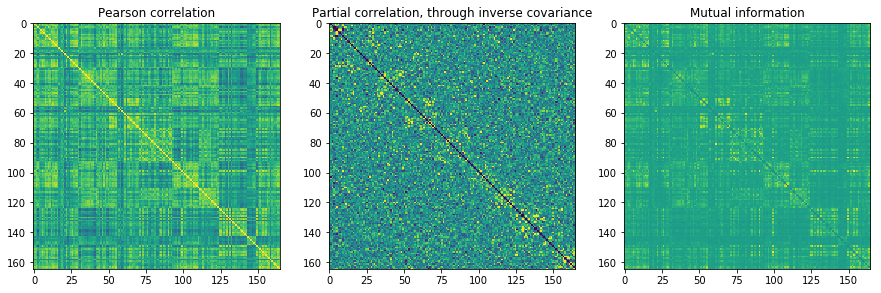

In [64]:
# plot the functional connectomes:
from sklearn import mixture
import matplotlib.mlab as mlab

f = plt.figure(figsize=(15,15))
subf1 = f.add_subplot(131)
subf1.imshow(pearsonr, clim=[-1,1])
#subf1.set_xticks(np.arange(0,len(labels)-1,1))
#subf1.set_xticklabels(labels,rotation=90)
#subf1.set_yticks(np.arange(0,len(labels)-1,1))
#subf1.set_yticklabels(labels)
plt.title('Pearson correlation')

subf2 = f.add_subplot(132)
subf2.imshow(partial_correlation2, clim=[-0.2,0.2])
plt.title('Partial correlation, through inverse covariance')

subf3 = f.add_subplot(133)
subf3.imshow(matMI, clim=[-1,1])
plt.title('Mutual information')
plt.show()

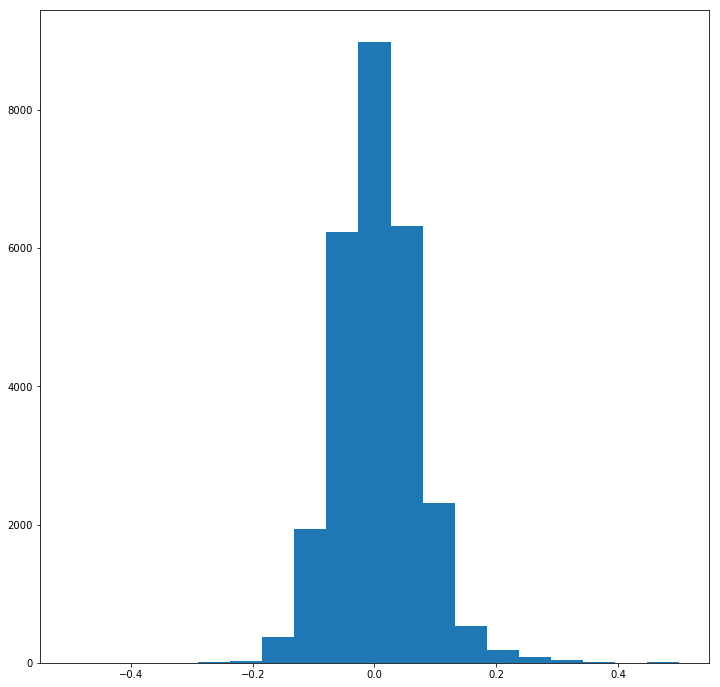

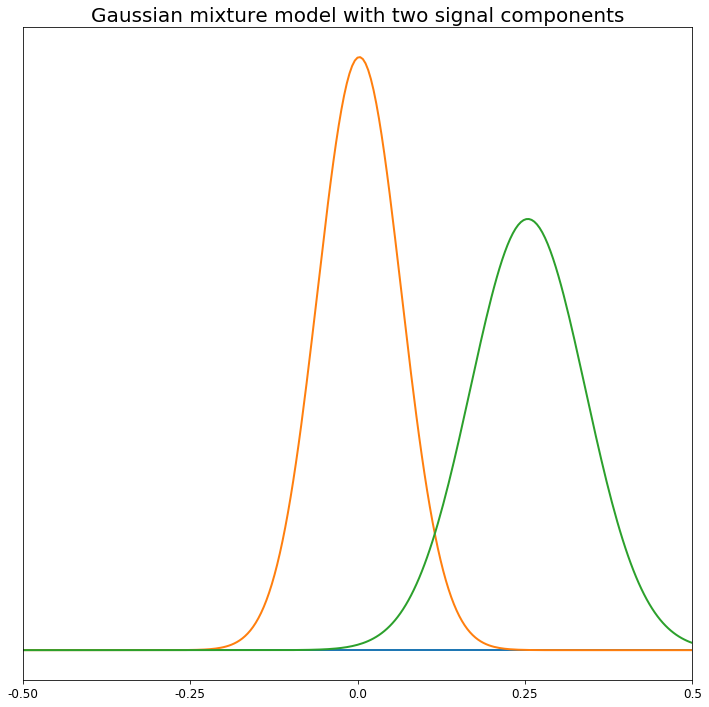

[[-1.        ]
 [ 0.00284699]
 [ 0.25436446]]
[ 0.00606061  0.98330968  0.01062972]


In [66]:
# Mixture modeling for partial correlation:
partial_correlation_vec = np.reshape(partial_correlation2,(Nvars*Nvars,1))
weights_init=np.zeros((3,))
weights_init[0]=0.10
weights_init[1]=0.80
weights_init[2]=0.10

# Initiate the means (the pseudo-null at zero):
means_init=np.zeros((3,1))
means_init[0,0]=-0.5
means_init[1,0]=0.0 
means_init[2,0]=0.5 
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full', weights_init=weights_init, means_init=means_init).fit(partial_correlation_vec)

comp1_mean = gmm.means_[0,0]
comp2_mean = gmm.means_[1,0]
comp3_mean = gmm.means_[2,0]
comp1_std = np.sqrt(gmm.covariances_[0])[0,0]
comp2_std = np.sqrt(gmm.covariances_[1])[0,0]
comp3_std = np.sqrt(gmm.covariances_[2])[0,0]

# plot the histogram for partial correlation:
bins = np.linspace(-0.5, 0.5, 20)
plt.figure(figsize=(12,12))
plt.hist(partial_correlation_vec, bins)  
plt.show()

# plot the mixture model:
plt.figure(figsize=(12,12))
plt.title('Gaussian mixture model with two signal components', fontsize=20)
plt.yticks([])
plt.xticks([-0.50,-0.25,0.0,0.25,0.5], ['-0.50','-0.25','0.0','0.25','0.5'], fontsize=12)
x = np.linspace(-1.0, 1.0, 501)
plt.xlim([-0.5,0.5])

y1 = gmm.weights_[0]*mlab.normpdf(x, comp1_mean, comp1_std)
plt.plot(x, y1, linewidth=2.0)
y2 = gmm.weights_[1]*mlab.normpdf(x, comp2_mean, comp2_std)
plt.plot(x, y2, linewidth=2.0)
y3 = gmm.weights_[1]*mlab.normpdf(x, comp3_mean, comp3_std)
plt.plot(x, y3, linewidth=2.0)
plt.show()

print gmm.means_
print gmm.weights_